In [1]:
import  numpy as np
import matplotlib.pyplot as plt
import  argparse
import  torch
from zIncipientFaultNShotMixup import IncipientFaultNShotMixup_taskInitial, IncipientFaultNShotMixup_test_adaptationlam
from meta import Meta

In [ ]:
argparser = argparse.ArgumentParser()
# argparser.add_argument('--epoch', type=int, help='epoch number', default=40000)
# argparser.add_argument('--n_way', type=int, help='n way', default=5)
# argparser.add_argument('--task_num', type=int, help='meta batch size, namely task num', default=32)
argparser.add_argument('--epoch', type=int, help='epoch number', default=400) #我设置的是1000
argparser.add_argument('--n_way', type=int, help='n way', default=3) #5
argparser.add_argument('--k_spt', type=int, help='k shot for support set', default=3)
argparser.add_argument('--k_spt_test', type=int, help='k shot for support set', default=4)
argparser.add_argument('--k_qry', type=int, help='k shot for query set', default=2) #15
argparser.add_argument('--k_qry_test', type=int, help='k shot for query set', default=10)  # 10
argparser.add_argument('--imgsz', type=int, help='imgsize', default=256)#28 64
argparser.add_argument('--imgc', type=int, help='imgchannels', default=3)
argparser.add_argument('--task_num', type=int, help='meta batch size, namely task num', default=4)
argparser.add_argument('--task_num_test', type=int, help='meta batch size, namely task num', default=1)
argparser.add_argument('--meta_lr', type=float, help='meta-level outer learning rate', default=1e-3)
argparser.add_argument('--update_lr', type=float, help='task-level inner update learning rate', default=0.1)#0.4
argparser.add_argument('--update_step', type=int, help='task-level inner update steps', default=5)
argparser.add_argument('--update_step_test', type=int, help='update steps for finetunning', default=10)#10
# args = argparser.parse_args()
# Filter out unrecognized arguments
args, unknown = argparser.parse_known_args()

In [3]:
seed = 222
np.random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if hasattr(torch.cuda, 'empty_cache'):
    torch.cuda.empty_cache()
print(args)
#初始的参数
config = [
    # ****************6层卷积层参数设置256*********************
    ('conv2d', [64, 3, 3, 3, 2, 0]),  # 64种1通道3乘3卷积核 步长2 padding 0
    ('relu', [True]),
    ('bn', [64]),
    ('conv2d', [64, 64, 3, 3, 2, 0]),
    ('relu', [True]),
    ('bn', [64]),
    ('conv2d', [64, 64, 3, 3, 2, 0]),
    ('relu', [True]),
    ('bn', [64]),
    ('conv2d', [64, 64, 3, 3, 2, 0]),
    ('relu', [True]),
    ('bn', [64]),
    ('conv2d', [64, 64, 3, 3, 3, 0]),
    ('relu', [True]),
    ('bn', [64]),
    ('conv2d', [64, 64, 3, 3, 2, 0]),
    ('relu', [True]),
    ('bn', [64]),
    ('flatten', []),
    # ('linear', [16, 256]),
    ('relu', [True]),
    ('linear', [args.n_way, 256])
    # ****************6层卷积层参数设置256*********************
]

Namespace(epoch=400, n_way=3, k_spt=3, k_spt_test=4, k_qry=2, k_qry_test=10, imgsz=256, imgc=3, task_num=4, task_num_test=1, meta_lr=0.001, update_lr=0.1, update_step=5, update_step_test=10)


In [4]:
device = torch.device('cuda')
maml = Meta(args, config).to(device)

In [5]:
tmp = filter(lambda x: x.requires_grad, maml.parameters()) ## filter
num = sum(map(lambda x: np.prod(x.shape), tmp)) #计算数组元素的乘积，得到所有需要训练向量的个数
print(maml)
print('Total trainable tensors:', num)

Meta(
  (net): Learner(
    (vars): ParameterList(
        (0): Parameter containing: [torch.float32 of size 64x3x3x3 (cuda:0)]
        (1): Parameter containing: [torch.float32 of size 64 (cuda:0)]
        (2): Parameter containing: [torch.float32 of size 64 (cuda:0)]
        (3): Parameter containing: [torch.float32 of size 64 (cuda:0)]
        (4): Parameter containing: [torch.float32 of size 64x64x3x3 (cuda:0)]
        (5): Parameter containing: [torch.float32 of size 64 (cuda:0)]
        (6): Parameter containing: [torch.float32 of size 64 (cuda:0)]
        (7): Parameter containing: [torch.float32 of size 64 (cuda:0)]
        (8): Parameter containing: [torch.float32 of size 64x64x3x3 (cuda:0)]
        (9): Parameter containing: [torch.float32 of size 64 (cuda:0)]
        (10): Parameter containing: [torch.float32 of size 64 (cuda:0)]
        (11): Parameter containing: [torch.float32 of size 64 (cuda:0)]
        (12): Parameter containing: [torch.float32 of size 64x64x3x3 (cuda:

In [6]:
db_train = IncipientFaultNShotMixup_taskInitial('TrainData7.19Mixup',
                       batchsz=args.task_num,
                       n_way=args.n_way,
                       k_shot=args.k_spt,
                       k_query=args.k_qry,
                       imgsz=args.imgsz,
                       chan=args.imgc)
mean,std=db_train.normalization()

load Incipient fault
data shape: (57, 6, 3, 256, 256)
Train task DB: train (57, 6, 3, 256, 256) test (57, 6, 3, 256, 256)


In [7]:
mean,std

(2.9900356e-09, 1.0)

In [8]:
db_test = IncipientFaultNShotMixup_test_adaptationlam('Data6Sim',
                                                   batchsz=args.task_num_test,
                                                   n_way=args.n_way,
                                                   k_shot=args.k_spt_test,
                                                   k_query=args.k_qry_test,
                                                   imgsz=args.imgsz,
                                                   chan=args.imgc, mean=mean, std=std,
                                                   )

load Incipient fault
data shape: (3, 14, 256, 256, 3)
Test task DB: train (3, 14, 256, 256, 3) test (3, 14, 256, 256, 3)


In [9]:
print('db_test',db_test)
acc_array=[]

db_test <zIncipientFaultNShotMixup.IncipientFaultNShotMixup_test_adaptationlam object at 0x7f98ab7595e0>


In [10]:
for step in range(args.epoch):
    print('step',step)
    if step == args.epoch-1:
        TorF = True
    else:
        TorF = False

    [x_spt, y_spt, x_qry, y_qry],rms_temp = db_train.next()
    x_spt, y_spt, x_qry, y_qry = torch.from_numpy(x_spt).to(device), torch.from_numpy(y_spt).to(device), \
                                 torch.from_numpy(x_qry).to(device), torch.from_numpy(y_qry).to(device)
    # x_spt, y_spt, x_qry, y_qry = torch.from_numpy(x_spt), torch.from_numpy(y_spt), \
    #                                 torch.from_numpy(x_qry), torch.from_numpy(y_qry)
    rms_temp=np.array(rms_temp)
    rms_temp=rms_temp.reshape(args.task_num,args.n_way)

    # plt.imshow(x_spt[0][0][0]).plt.show()
    # set traning=True to update running_mean, running_variance, bn_weights, bn_bias
    accs = maml(x_spt, y_spt, x_qry, y_qry,rms_temp)
    train_acc=accs[-1]
    # wandb.log({
    #     "train_acc": train_acc,
    # })
    if step % 50 == 0:
        print('step:', step, '\ttraining acc:', accs)

    if step % 100 == 0:
        accs = []
        accs_last=[]
        macro_precisions=[]
        macro_f1s=[]
        macro_recalls=[]

        # ccc=1000//args.task_num
        for _ in range(100//args.task_num):

            # test
            x_spt, y_spt, x_qry, y_qry = db_test.next('test')
            x_spt, y_spt, x_qry, y_qry = torch.from_numpy(x_spt).to(device), torch.from_numpy(y_spt).to(device), \
                                         torch.from_numpy(x_qry).to(device), torch.from_numpy(y_qry).to(device)
            # x_spt, y_spt, x_qry, y_qry = torch.from_numpy(x_spt), torch.from_numpy(y_spt), \
            #                                 torch.from_numpy(x_qry), torch.from_numpy(y_qry)

            # split to single task each time
            for x_spt_one, y_spt_one, x_qry_one, y_qry_one in zip(x_spt, y_spt, x_qry, y_qry):
                # len(x_spt_one) = 12
                # y_spt_one = tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2])
                # y_qry_one = tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
                # print(len(x_spt_one), y_spt_one, x_qry_one, y_qry_one)
                test_acc,acc,macro_precision,macro_f1,macro_recall = maml.finetunning(x_spt_one, y_spt_one, x_qry_one, y_qry_one, TorF)
                accs_last.append(acc)
                macro_precisions.append(macro_precision)
                macro_f1s.append(macro_f1)
                macro_recalls.append(macro_recall)
                accs.append(test_acc)

        # [b, update_step+1]
        accs = np.array(accs).mean(axis=0).astype(np.float16)
        accs_last=np.array(accs_last).mean(axis=0).astype(np.float16)
        macro_precisions = np.array(macro_precisions).mean(axis=0).astype(np.float16)
        macro_f1s = np.array(macro_f1s).mean(axis=0).astype(np.float16)
        macro_recalls = np.array(macro_recalls).mean(axis=0).astype(np.float16)
        print('Test acc:', accs)
        print('Test macro_precisions:', macro_precisions)
        print('Test macro_f1s:', macro_f1s)
        print('Test macro_recalls:', macro_recalls)

        test_acc = accs
        acc_array.append(test_acc[-1])


step 0
step: 0 	training acc: [0.25       0.45833333 0.58333333 0.58333333 0.58333333 0.58333333]
Test acc: [0.3467 0.8706 0.88   0.8813 0.883  0.884  0.884  0.884  0.8853 0.8867
 0.8867]
Test macro_precisions: 0.9014
Test macro_f1s: 0.884
Test macro_recalls: 0.8867
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50
step: 50 	training acc: [0.375      0.54166667 0.79166667 0.79166667 0.79166667 0.79166667]
step 51
step 52
step 53
step 54
step 55
step 56
step 57
step 58
step 59
step 60
step 61
step 62
step 63
step 64
step 65
step 66
step 67
step 68
step 69
step 70
step 71
step 72
step 73
step 74
step 75
step 76
step 77
step 78
step 79
step 80
step 81
st

In [11]:
print(db_test.temp_dict)

{'Incipient Fault/cable/cable2': {'MixedImg/cable20mixed_img.jpg': array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
       

In [12]:
dat = db_test.temp_dict['Incipient Fault/cable/cable2']['MixedImg/cable20mixed_img.jpg']

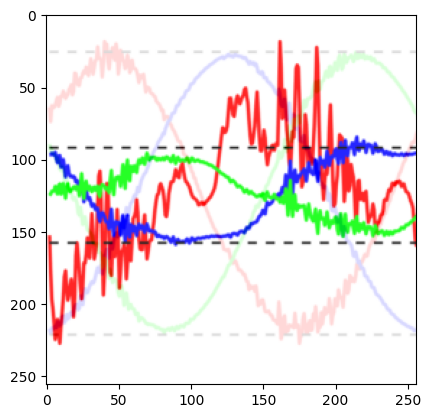

In [13]:
import matplotlib.pyplot as plt

plt.imshow(dat)
plt.show()

In [14]:
import pickle

with open('db_test_temp_dict.pkl', 'wb') as f:
    pickle.dump(db_test.temp_dict, f)

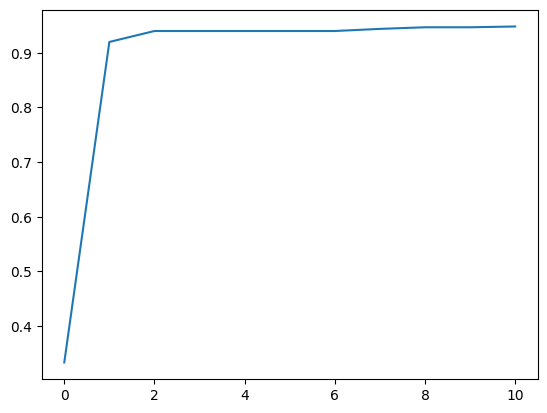

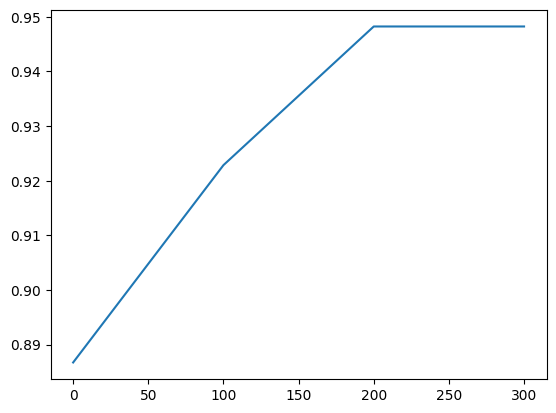

In [15]:
y=range(0, args.update_step_test+1, 1)
y=list(y)
plt.plot(y, test_acc)
plt.show()
x=range(0, args.epoch, 100)
x=list(x)
plt.plot(x, acc_array)
plt.show()